In [1]:
# 1/24/2022
# markstro
#
# This notebook demos: (1) how to read the CBH file and adjust the values for the HRUS; (2) determine the
# form of the precip' (3) read values from the parameter file and use them in calculations.

In [2]:
import pandas as pd
import numpy as np
import gc
import sys
import os
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
import math


In [3]:
pfn = "../prms_models/box01/input/box01.params"
outdir = "../prms_models/box01/output/"
indir = "../prms_models/box01/input/"

# Utility functions

In [4]:
# Function that will read PRMS parameter file
# Returns the contents of param file in python data structures
def read_param_file(pfn):
    line_num = 0
    vals = {}
    dims = {}
    param_dims = {}
    param_type = {}

    with open(pfn) as f:
        reading_dims = False
        for line in f:
            try:
                line = line.rstrip()  # remove '\n' at end of line
                line_num += 1
                if line == '** Dimensions **':
                    reading_dims = True
                    line = f.readline().rstrip() 
                    line_num += 1

                if line == '** Parameters **':
                    reading_dims = False
                    break

                if reading_dims:
                    line = f.readline().rstrip()
                    line_num += 1
                    dim_name = line
                    
                    line = f.readline().rstrip() 
                    line_num += 1
                    size = line
                    
                    if dim_name in dims.keys():
                        pass
                    else:
                        dims[dim_name] = int(size)
            except:
                print("**** read parameters exception line = ", line)
                print("**** read parameters exception line_num = ", str(line_num))
                print("**** Unexpected error:", sys.exc_info()[0])

#        read params
        for line in f:
            try:
                line = line.rstrip()  # remove '\n' at end of line
                line_num += 1

                if line == "####":
                    line = f.readline().rstrip()
                    line = line.split(' ', 1)[0]  # old format parameter files have a blank (' ') and then a width format value. Strip this off.
                    param_name = line
                    line_num += 1

                    line = f.readline().rstrip()
                    line_num += 1
                    num_dims = int(line)
                    pd = [None] * num_dims
                    for ii in range(num_dims):
                        line = f.readline().rstrip()
                        pd[ii] = line
                        line_num += 1

                    param_dims[param_name] = pd

                    line = f.readline().rstrip()
                    line_num += 1
                    num_vals = int(line)
                    line = f.readline().rstrip()
                    line_num += 1
                    tp = int(line)
                    param_type[param_name] = tp

                    if tp == 2:
                        vs = np.zeros(num_vals, dtype=float)
                        for jj in range(num_vals):
                            line = f.readline().rstrip()
                            line_num += 1
                            vs[jj] = float(line.split()[0])

                    elif tp == 1:
                        vs = np.zeros(num_vals, dtype=int)
                        for jj in range(num_vals):
                            line = f.readline().rstrip()
                            line_num += 1
                            vs[jj] = int(line.split()[0])

                    else:
                        vs = np.zeros(num_vals, dtype=np.chararray)
                        for jj in range(num_vals):
                            line = f.readline().rstrip()
                            line_num += 1
                            vs[jj] = line

                    if num_dims == 2:
                        vs.shape = (dims[pd[1]], dims[pd[0]])

                    if param_name in vals.keys():
                        print("parameter ", param_name, " is already in ", pfn)
                    else:
                        vals[param_name] = vs

            except:
                print("read parameters exception line_num = ", str(line_num))
                print("Unexpected error:", sys.exc_info()[0])
                
    gc.collect()
    
    return (dims, vals, param_dims, param_type)

In [5]:
# I don't understand why I needed to write this function myself
# Input: datetime.Date
# Output: day of the year (aka "Julian date")
def day_of_year(d):
    N1 = math.floor(275 * d.month / 9)
    N2 = math.floor((d.month + 9) / 12)
    N3 = (1 + math.floor((d.year - 4 * math.floor(d.year / 4) + 2) / 3))
    N = N1 - (N2 * N3) + d.day - 30
    return N

# Read the simulated output into a dataframe

In [6]:
# This loops over all of the csv files in the output directory

sim_vals = None
for filename in os.listdir(outdir):
    f = os.path.join(outdir,filename)
    if os.path.isfile(f) and f.endswith('.csv'):
        varname = filename.split('.')[0]
        
        if sim_vals is None:
            sim_vals = pd.read_csv(f, names=["datestr", varname], skiprows=1)
            
        else:
            if varname != 'stats':
                df = pd.read_csv(f, names=["datestr", varname], skiprows=1)
                sim_vals = pd.merge(sim_vals, df[["datestr", varname]], on="datestr", how="left")

sim_vals["date"] = [datetime.strptime(date, '%Y-%m-%d').date() for date in sim_vals["datestr"]]
del sim_vals['datestr']

In [7]:
sim_vals.head()

,soil_moist_tot,hru_impervstor,net_snow,net_ppt,hru_sroffp,hru_snow,tmaxf,hortonian_flow,tminf,intcp_stor,canopy_covden,net_rain,intcp_evap,hru_ppt,hru_sroffi,hru_rain,hru_impervevap,date
0,0.0000,0.0,0.0,0.0000,0.0000,0.0,78.5987,0.0000,49.7339,0.0000,0.2308,0.0000,0.0000,0.0000,0.0,0.0000,0.0,1980-10-01
1,0.0926,0.0,0.0,0.1030,0.0000,0.0,77.5987,0.0000,51.5339,0.0038,0.2308,0.1030,0.0000,0.1039,0.0,0.1039,0.0,1980-10-02
2,0.3290,0.0,0.0,0.2629,0.0001,0.0,66.2987,0.0001,51.1339,0.0038,0.2308,0.2629,0.0000,0.2629,0.0,0.2629,0.0,1980-10-03
3,0.3684,0.0,0.0,0.0672,0.0000,0.0,66.2987,0.0000,45.0339,0.0038,0.2308,0.0672,0.0000,0.0672,0.0,0.0672,0.0,1980-10-04
4,0.3468,0.0,0.0,0.0000,0.0000,0.0,63.0987,0.0000,42.9339,0.0000,0.2308,0.0000,0.0038,0.0000,0.0,0.0000,0.0,1980-10-05


In [8]:
sim_vals.tail()

,soil_moist_tot,hru_impervstor,net_snow,net_ppt,hru_sroffp,hru_snow,tmaxf,hortonian_flow,tminf,intcp_stor,canopy_covden,net_rain,intcp_evap,hru_ppt,hru_sroffi,hru_rain,hru_impervevap,date
14331,2.0748,0.0,0.0,0.0000,0.0000,0.0,49.9269,0.0000,34.6239,0.0000,0.2308,0.0000,0.0,0.0000,0.0,0.0000,0.0,2019-12-27
14332,2.0376,0.0,0.0,0.0000,0.0000,0.0,47.6269,0.0000,29.5239,0.0000,0.2308,0.0000,0.0,0.0000,0.0,0.0000,0.0,2019-12-28
14333,2.4328,0.0,0.0,0.7713,0.2080,0.0,41.1269,0.2080,30.0239,0.0038,0.2308,0.7713,0.0,0.7722,0.0,0.7722,0.0,2019-12-29
14334,2.5656,0.0,0.0,0.8332,0.3527,0.0,38.9269,0.3527,35.0239,0.0038,0.2308,0.8332,0.0,0.8332,0.0,0.8332,0.0,2019-12-30
14335,2.4854,0.0,0.0,0.1118,0.0211,0.0,43.1269,0.0211,35.7239,0.0038,0.2308,0.1118,0.0,0.1118,0.0,0.1118,0.0,2019-12-31


# Read the CBH forcing data into the dataframe

In [9]:
def add_date_for_PRMS_dates(df):
    df["date"] = [date(y, m, d) for y, m, d in zip(df["yr"], df["mo"], df["da"])]
    del df["yr"]
    del df["mo"]
    del df["da"]
    del df["hr"]
    del df["mi"]
    del df["se"]
    return df

In [10]:
# Read the CBH forcing inputs
cbh_vals = None
for filename in os.listdir(indir):
    f = os.path.join(indir,filename)
    if os.path.isfile(f) and f.endswith('.cbh'):
        varname = filename.split('.')[0]
        
        if cbh_vals is None:
            cbh_vals = pd.read_csv(f, names=["yr", "mo", "da", "hr", "mi", "se", varname], skiprows=3, delim_whitespace=True)
            cbh_vals = add_date_for_PRMS_dates(cbh_vals)

        else:
            foo = pd.read_csv(f, names=["yr", "mo", "da", "hr", "mi", "se", varname], skiprows=3, delim_whitespace=True)
            foo = add_date_for_PRMS_dates(foo)
            cbh_vals = pd.merge(cbh_vals, foo[["date", varname]], on="date", how="left")

In [11]:
cbh_vals.head()

,tmin,date,tmax,prcp
0,31.0,1979-01-01,43.6,0.00
1,31.0,1979-01-02,47.2,0.04
2,34.1,1979-01-03,53.0,0.02
3,38.2,1979-01-04,53.7,0.49
4,34.9,1979-01-05,42.9,0.48


In [12]:
cbh_vals.tail()

,tmin,date,tmax,prcp
14977,34.2,2019-12-27,50.6,0.00
14978,29.1,2019-12-28,48.3,0.00
14979,29.6,2019-12-29,41.8,0.76
14980,34.6,2019-12-30,39.6,0.82
14981,35.3,2019-12-31,43.8,0.11


# Sync up the dates of the forcings and the outputs. This makes sure that all values are compared for the same date(s)

In [13]:
synced_vals = pd.merge(cbh_vals, sim_vals, on="date", how="right")

In [14]:
print(synced_vals.shape)

(14336, 21)


In [15]:
synced_vals.head()

,tmin,date,tmax,prcp,soil_moist_tot,hru_impervstor,net_snow,net_ppt,hru_sroffp,hru_snow,...,hortonian_flow,tminf,intcp_stor,canopy_covden,net_rain,intcp_evap,hru_ppt,hru_sroffi,hru_rain,hru_impervevap
0,50.1,1980-10-01,77.5,0.00,0.0000,0.0,0.0,0.0000,0.0000,0.0,...,0.0000,49.7339,0.0000,0.2308,0.0000,0.0000,0.0000,0.0,0.0000,0.0
1,51.9,1980-10-02,76.5,0.17,0.0926,0.0,0.0,0.1030,0.0000,0.0,...,0.0000,51.5339,0.0038,0.2308,0.1030,0.0000,0.1039,0.0,0.1039,0.0
2,51.5,1980-10-03,65.2,0.43,0.3290,0.0,0.0,0.2629,0.0001,0.0,...,0.0001,51.1339,0.0038,0.2308,0.2629,0.0000,0.2629,0.0,0.2629,0.0
3,45.4,1980-10-04,65.2,0.11,0.3684,0.0,0.0,0.0672,0.0000,0.0,...,0.0000,45.0339,0.0038,0.2308,0.0672,0.0000,0.0672,0.0,0.0672,0.0
4,43.3,1980-10-05,62.0,0.00,0.3468,0.0,0.0,0.0000,0.0000,0.0,...,0.0000,42.9339,0.0000,0.2308,0.0000,0.0038,0.0000,0.0,0.0000,0.0


In [16]:
synced_vals.tail()

,tmin,date,tmax,prcp,soil_moist_tot,hru_impervstor,net_snow,net_ppt,hru_sroffp,hru_snow,...,hortonian_flow,tminf,intcp_stor,canopy_covden,net_rain,intcp_evap,hru_ppt,hru_sroffi,hru_rain,hru_impervevap
14331,34.2,2019-12-27,50.6,0.00,2.0748,0.0,0.0,0.0000,0.0000,0.0,...,0.0000,34.6239,0.0000,0.2308,0.0000,0.0,0.0000,0.0,0.0000,0.0
14332,29.1,2019-12-28,48.3,0.00,2.0376,0.0,0.0,0.0000,0.0000,0.0,...,0.0000,29.5239,0.0000,0.2308,0.0000,0.0,0.0000,0.0,0.0000,0.0
14333,29.6,2019-12-29,41.8,0.76,2.4328,0.0,0.0,0.7713,0.2080,0.0,...,0.2080,30.0239,0.0038,0.2308,0.7713,0.0,0.7722,0.0,0.7722,0.0
14334,34.6,2019-12-30,39.6,0.82,2.5656,0.0,0.0,0.8332,0.3527,0.0,...,0.3527,35.0239,0.0038,0.2308,0.8332,0.0,0.8332,0.0,0.8332,0.0
14335,35.3,2019-12-31,43.8,0.11,2.4854,0.0,0.0,0.1118,0.0211,0.0,...,0.0211,35.7239,0.0038,0.2308,0.1118,0.0,0.1118,0.0,0.1118,0.0


# Now that the inputs are read, the code below verifies model performance

In [17]:
# can use the same "dates" array for all analysis
dates = synced_vals["date"].values

In [18]:
tmax = synced_vals["tmax"].values
tmin = synced_vals["tmin"].values
prcp = synced_vals["prcp"].values

# Read the necessary values from the parameter file

In [19]:
params = read_param_file(pfn)
vals = params[1]

tmax_allsnow = vals["tmax_allsnow"]
snow_cbh_adj = vals["snow_cbh_adj"]
rain_cbh_adj = vals["rain_cbh_adj"]
tmax_cbh_adj = vals["tmax_cbh_adj"]
tmin_cbh_adj = vals["tmin_cbh_adj"]
tmax_allrain_offset = vals["tmax_allrain_offset"]
tmax_allrain = tmax_allsnow + tmax_allrain_offset
adjmix_rain = vals["adjmix_rain"]

In [20]:
print(snow_cbh_adj)

[[0.7412   ]
 [1.3062946]
 [1.29966  ]
 [1.       ]
 [0.8445461]
 [1.       ]
 [1.       ]
 [1.       ]
 [0.7092881]
 [0.7251823]
 [0.7410765]
 [0.7412   ]]


In [21]:
# Dumb check, but simulation depends on this

tiff = tmax - tmin
print("there are", np.sum(np.array(tiff)) < 0, "negative values")
print("there are", np.sum(np.array(tiff)) == 0, "equal values")

there are False negative values
there are False equal values


# Check the adjusted forcing temperature against tmaxf and tminf

In [22]:
# Compute the adjusted HRU temperature

tmax_hru = np.zeros(len(dates))
tmin_hru = np.zeros(len(dates))

ii = 0
for date in dates:
    jday = day_of_year(date)
    imon = date.month - 1
    tmax_hru[ii] = tmax[ii] + tmax_cbh_adj[imon]
    tmin_hru[ii] = tmin[ii] + tmin_cbh_adj[imon]
    ii += 1

In [23]:
err = synced_vals["tmaxf"].values - tmax_hru
print(sum(synced_vals["tmaxf"].values), sum(tmax_hru))

868664.8405999996 868664.9429676953


(array([ 1826.,  3652.,  5479.,  7305.,  9131., 10957., 12784., 14610.,
        16436., 18262., 20089.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

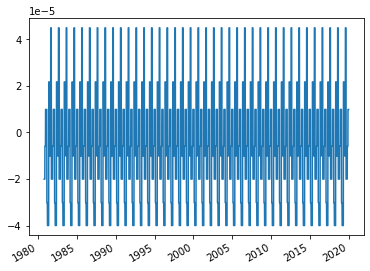

In [24]:
plt.plot(dates, err)
plt.xticks(rotation=30, ha='right')

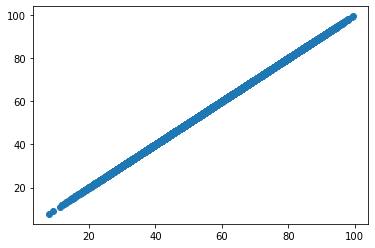

In [25]:
plt.scatter(synced_vals["tmaxf"].values, tmax_hru)

In [26]:
err = synced_vals["tminf"].values - tmin_hru
print(sum(synced_vals["tminf"].values), sum(tmin_hru))

629135.4826999907 629135.3182070097


(array([ 1826.,  3652.,  5479.,  7305.,  9131., 10957., 12784., 14610.,
        16436., 18262., 20089.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

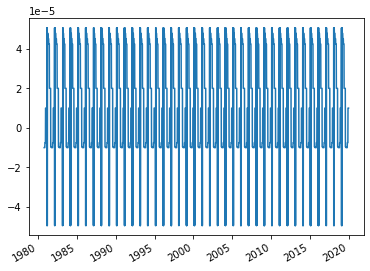

In [27]:
plt.plot(dates, err)
plt.xticks(rotation=30, ha='right')

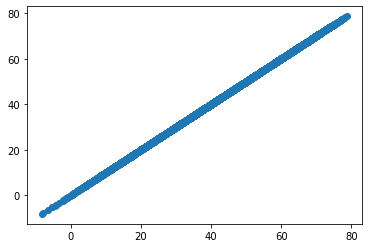

In [28]:
plt.scatter(synced_vals["tminf"].values, tmin_hru)

# compute the precip form and the adjusted precip

In [29]:
hru_ppt = np.zeros(len(dates))
hru_snow = np.zeros(len(dates))
hru_rain = np.zeros(len(dates))

# Be sure and use the ajdusted HRU temperatures
# This version of adjusted temperatures are read as output from PRMS
# tmaxf = synced_vals["tmaxf"].values
# tminf = synced_vals["tminf"].values

# This version of adjusted temperatures are computed by python above
tmaxf = tmax_hru
tminf = tmin_hru

ii = 0
for date in dates:
    jday = day_of_year(date)
    imon = date.month - 1

    if tmaxf[ii] <= tmax_allsnow[imon]:
        hru_ppt[ii] = prcp[ii] * snow_cbh_adj[imon]
        hru_snow[ii] = hru_ppt[ii]
        prmx = 0.0

    elif (tminf[ii] > tmax_allsnow[imon]) or (tmaxf[ii] >= tmax_allrain[imon]):
        hru_ppt[ii] = prcp[ii] * rain_cbh_adj[imon]
        hru_rain[ii] = hru_ppt[ii]
        prmx = 1.0
        
    else:
        tdiff = tmaxf[ii] - tminf[ii]
        prmx = ((tmaxf[ii] - tmax_allsnow[imon]) / (tmaxf[ii] - tminf[ii])) * adjmix_rain[imon]

        if prmx < 1.0:
            hru_ppt[ii] = prcp[ii] * snow_cbh_adj[imon]
            hru_rain[ii] = prmx * hru_ppt[ii]
            hru_snow[ii] = hru_ppt[ii] - hru_rain[ii]
        else:
            hru_ppt[ii] = prcp[ii] * rain_cbh_adj[imon]
            hru_rain[ii] = hru_ppt[ii]
    ii += 1

In [30]:
err = synced_vals["hru_ppt"].values - hru_ppt
print(sum(synced_vals["hru_ppt"].values), sum(hru_ppt))

2019.1698999999828 2019.1734365229845


(array([ 1826.,  3652.,  5479.,  7305.,  9131., 10957., 12784., 14610.,
        16436., 18262., 20089.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

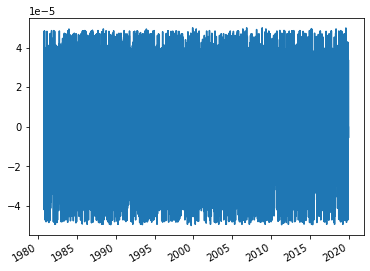

In [31]:
plt.plot(dates, err)
plt.xticks(rotation=30, ha='right')

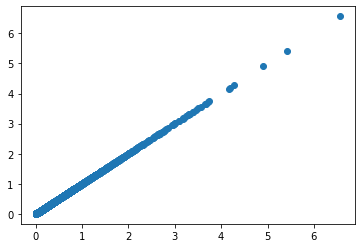

In [32]:
plt.scatter(synced_vals["hru_ppt"].values, hru_ppt)

In [33]:
err = synced_vals["hru_rain"].values - hru_rain

(array([ 1826.,  3652.,  5479.,  7305.,  9131., 10957., 12784., 14610.,
        16436., 18262., 20089.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

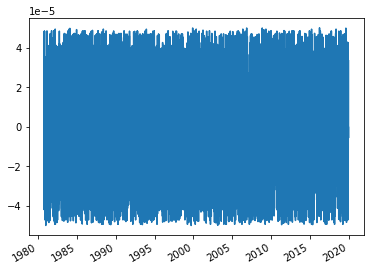

In [34]:
plt.plot(dates, err)
plt.xticks(rotation=30, ha='right')

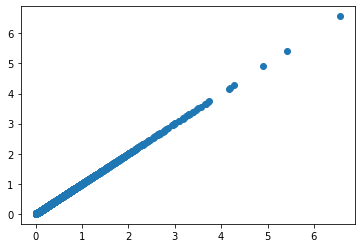

In [35]:
plt.scatter(synced_vals["hru_rain"].values, hru_rain)

In [36]:
err = synced_vals["hru_snow"].values - hru_snow

(array([ 1826.,  3652.,  5479.,  7305.,  9131., 10957., 12784., 14610.,
        16436., 18262., 20089.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

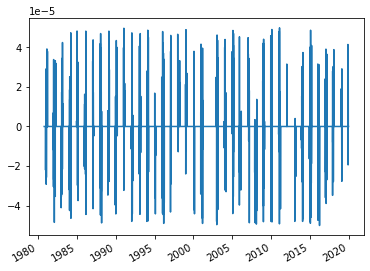

In [37]:
plt.plot(dates, err)
plt.xticks(rotation=30, ha='right')

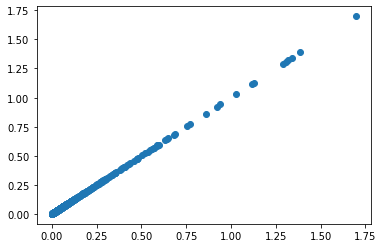

In [38]:
plt.scatter(synced_vals["hru_snow"].values, hru_snow)